In [52]:
from datetime import datetime
import time,pytz
import os, glob, subprocess, sys, uuid
from tqdm import tqdm

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "1"
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

import keras

import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

GLOBAL_RANDOM_SEED = 42

random.seed(GLOBAL_RANDOM_SEED)
np.random.seed(GLOBAL_RANDOM_SEED)
tf.random.set_seed(GLOBAL_RANDOM_SEED)
tf.config.experimental.enable_op_determinism()
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
initializer = keras.initializers.GlorotUniform(seed=GLOBAL_RANDOM_SEED)

ERROR:tensorflow:An interactive session is already active. This can cause out-of-memory errors or some other unexpected errors (due to the unpredictable timing of garbage collection) in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s). Please use `tf.Session()` if you intend to productionize.


I0000 00:00:1749455027.351173  149401 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5233 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [53]:
# ========== LOAD & CLEAN ==========
column_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"
]

files = [
    ("data/processed.cleveland.data", "cleveland"),
    ("data/processed.hungarian.data", "hungarian"),
    ("data/processed.switzerland.data", "switzerland"),
    ("data/processed.va.data", "va")
]

# Load data with source tracking
dfs = []
for file_path, source in files:
    temp_df = pd.read_csv(file_path, names=column_names, na_values='?', header=None)
    temp_df['source'] = source
    dfs.append(temp_df)

df = pd.concat(dfs, ignore_index=True)

# Convert columns to numeric, binarize target
for col in column_names:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

print(df.describe())

              age         sex          cp    trestbps        chol         fbs  \
count  920.000000  920.000000  920.000000  861.000000  890.000000  830.000000   
mean    53.510870    0.789130    3.250000  132.132404  199.130337    0.166265   
std      9.424685    0.408148    0.930969   19.066070  110.780810    0.372543   
min     28.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
25%     47.000000    1.000000    3.000000  120.000000  175.000000    0.000000   
50%     54.000000    1.000000    4.000000  130.000000  223.000000    0.000000   
75%     60.000000    1.000000    4.000000  140.000000  268.000000    0.000000   
max     77.000000    1.000000    4.000000  200.000000  603.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  918.000000  865.000000  865.000000  858.000000  611.000000  309.000000   
mean     0.604575  137.545665    0.389595    0.878788    1.770867    0.676375   
std      0.805827   25.9262

  Selector      Model  Accuracy  Precision   Recall  F1 Score      AUC                                                                          Selected Features
       PCA        SVM  0.842391   0.841121 0.882353  0.861244 0.922884                                        [PC1, PC2, PC3, PC4, PC5, PC6, PC7, PC8, PC9, PC10]
MutualInfo RandForest  0.831522   0.844660 0.852941  0.848780 0.916726                 [age, cp, chol, thalach, exang, oldpeak, slope, ca, thal, src_switzerland]
   ReliefF RandForest  0.836957   0.846154 0.862745  0.854369 0.916368 [exang, cp, ca, thal, oldpeak, src_hungarian, chol, src_cleveland, slope, src_switzerland]
      Chi2        SVM  0.820652   0.834951 0.843137  0.839024 0.915770         [sex, cp, thalach, exang, slope, ca, thal, src_hungarian, src_switzerland, src_va]
   ReliefF     LogReg  0.836957   0.882979 0.813725  0.846939 0.915591 [exang, cp, ca, thal, oldpeak, src_hungarian, chol, src_cleveland, slope, src_switzerland]
      Chi2 RandForest  0.826

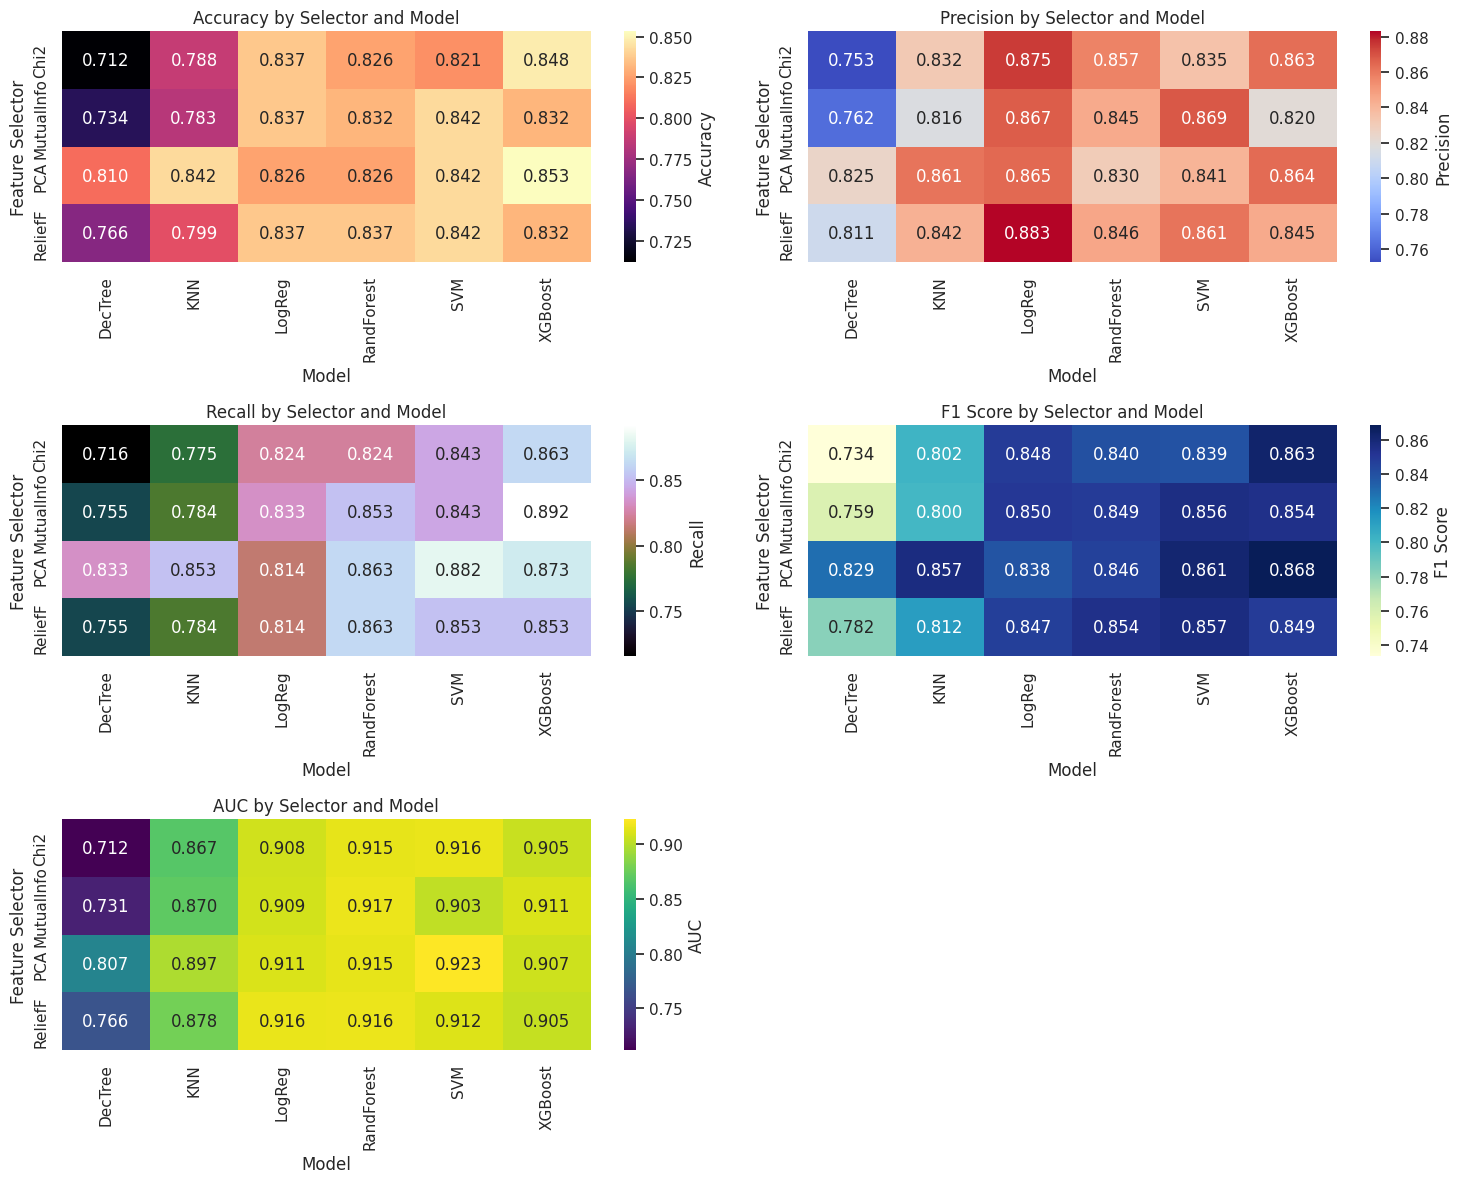

In [54]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from skrebate import ReliefF
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns

# ========== IMPUTATION ==========
dfs_imputed = []
for source in df['source'].unique():
    temp = df[df['source'] == source].copy()
    numeric_cols = temp.select_dtypes(include=[np.number]).columns.drop('target')
    imputer = KNNImputer(n_neighbors=min(5, len(temp)-1))
    temp[numeric_cols] = imputer.fit_transform(temp[numeric_cols])
    dfs_imputed.append(temp)

df = pd.concat(dfs_imputed, ignore_index=True)
df = pd.get_dummies(df, columns=['source'], prefix='src')
df = df.fillna(df.median())

# ========== SPLIT ==========
X = df.drop('target', axis=1)
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=GLOBAL_RANDOM_SEED
)

# ========== MODELS & SELECTORS ==========
models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "DecTree": DecisionTreeClassifier(),
    "RandForest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

selectors = {
    "Chi2": [("nonneg_shift", FunctionTransformer(lambda x: x - x.min(axis=0))), ("select", SelectKBest(chi2))],
    "MutualInfo": [("select", SelectKBest(mutual_info_classif))],
    "ReliefF": [("select", ReliefF())],
    # "PCA": [("reduce", PCA())]
    # "Chi2": [("nonneg_shift", FunctionTransformer(lambda x: x - x.min(axis=0))), ("select", SelectKBest(chi2, k=10))],
    # "MutualInfo": [("select", SelectKBest(mutual_info_classif, k=10))],
    # "ReliefF": [("select", ReliefF(n_features_to_select=10))],
    "PCA": [("reduce", PCA(n_components=10))] # forcing PCA to select only 10 made its AUC ~1.1% more accurate
}


# ========== PIPELINES, TRAIN and EVALUATION ==========
results = []

for sel_name, sel_steps in selectors.items():
    for model_name, model in models.items():
        steps = [("scaler", StandardScaler())] + sel_steps + [("smote", SMOTE(random_state=42)), ("model", model)]
        pipe = ImbPipeline(steps)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        y_proba = pipe.predict_proba(X_test)[:, 1]
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_proba)


        # Extract feature names
        try:
            if sel_name == "Chi2":
                mask = pipe.named_steps["select"].get_support()
                selected_features = X_train.columns[mask].tolist()
            elif sel_name == "MutualInfo":
                mask = pipe.named_steps["select"].get_support()
                selected_features = X_train.columns[mask].tolist()
            elif sel_name == "ReliefF":
                mask = pipe.named_steps["select"].top_features_[:10]
                selected_features = X_train.columns[mask].tolist()
            elif sel_name == "PCA":
                selected_features = [f"PC{i+1}" for i in range(pipe.named_steps["reduce"].n_components_)]
        except Exception as e:
            selected_features = [f"[Error extracting features: {str(e)}]"]

        results.append({
            "Selector": sel_name,
            "Model": model_name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1 Score": f1,
            "AUC": auc,
            "Selected Features": selected_features
        })

# ========== SUMMARY ==========
df_results = pd.DataFrame(results)
pd.set_option("display.max_colwidth", None)
print(df_results.sort_values(by="AUC", ascending=False).to_string(index=False))

# ========== HITMAPS ==========
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]
cmap_dict = {
    "Accuracy": "magma",
    "Precision": "coolwarm",
    "Recall": "cubehelix",
    "F1 Score": "YlGnBu",
    "AUC": "viridis"
}

plt.figure(figsize=(15, 12))
sns.set_theme(style="whitegrid")

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    metric_matrix = df_results.pivot(index="Selector", columns="Model", values=metric)
    sns.heatmap(metric_matrix, annot=True, fmt=".3f", cmap=cmap_dict[metric], cbar_kws={'label': metric})
    plt.title(f"{metric} by Selector and Model")
    plt.xlabel("Model")
    plt.ylabel("Feature Selector")

plt.tight_layout()
plt.show()

# auc_matrix = df_results.pivot(index="Selector", columns="Model", values="AUC")
# acc_matrix = df_results.pivot(index="Selector", columns="Model", values="Accuracy")

# plt.figure(figsize=(12, 6))
# sns.set_theme(style="whitegrid")

# # AUC heatmap
# plt.subplot(1, 2, 1)
# sns.heatmap(auc_matrix, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'AUC'})
# plt.title("AUC Scores by Selector and Model")
# plt.xlabel("Model")
# plt.ylabel("Feature Selector")

# # Accuracy heatmap
# plt.subplot(1, 2, 2)
# sns.heatmap(acc_matrix, annot=True, fmt=".3f", cmap="magma", cbar_kws={'label': 'Accuracy'})
# plt.title("Accuracy Scores by Selector and Model")
# plt.xlabel("Model")
# plt.ylabel("Feature Selector")

# plt.tight_layout()
# plt.show()


# # ========== PIPELINES ==========
# selector_pipelines = {
#     "ChiSq": ImbPipeline([
#         ("scaler", StandardScaler()),
#         ("nonneg_shift", FunctionTransformer(lambda x: x - x.min(axis=0))),  # Chi2 requires non-negative
#         # ("select", SelectKBest(chi2, k=10)),
#         ("select", SelectKBest(chi2)),
#         ("smote", SMOTE(random_state=GLOBAL_RANDOM_SEED)),
#         ("model", RandomForestClassifier(random_state=GLOBAL_RANDOM_SEED))
#     ]),
#     "MutualInfo": ImbPipeline([
#         ("scaler", StandardScaler()),
#         # ("select", SelectKBest(mutual_info_classif, k=10)),
#         ("select", SelectKBest(mutual_info_classif)),
#         ("smote", SMOTE(random_state=GLOBAL_RANDOM_SEED)),
#         ("model", RandomForestClassifier(random_state=GLOBAL_RANDOM_SEED))
#     ]),
#     "ReliefF": ImbPipeline([
#         ("scaler", StandardScaler()),
#         # ("select", ReliefF(n_features_to_select=10)),
#         ("select", ReliefF()),
#         ("smote", SMOTE(random_state=GLOBAL_RANDOM_SEED)),
#         ("model", RandomForestClassifier(random_state=GLOBAL_RANDOM_SEED))
#     ]),
#     "PCA": ImbPipeline([
#         ("scaler", StandardScaler()),
#         # ("reduce", PCA(n_components=10)),
#         ("reduce", PCA()),
#         ("smote", SMOTE(random_state=GLOBAL_RANDOM_SEED)),
#         ("model", RandomForestClassifier(random_state=GLOBAL_RANDOM_SEED))
#     ])
# }

# # ========== TRAIN & EVALUATE ==========
# results = {}

# for name, pipe in selector_pipelines.items():
#     print(f"\n=== {name} Pipeline ===")
#     pipe.fit(X_train, y_train)
#     y_pred = pipe.predict(X_test)
#     y_proba = pipe.predict_proba(X_test)[:, 1]

#     acc = accuracy_score(y_test, y_pred)
#     auc = roc_auc_score(y_test, y_proba)
#     print(f"AUC: {auc:.4f}, Accuracy: {acc:.4f}")
#     results[name] = {"AUC": auc, "Accuracy": acc}

# # ========== FEATURES SELECTED ==========
# print("\n=== Selected Features ===")
# feature_names = X_train.columns.tolist()

# for name, pipe in selector_pipelines.items():
#     print(f"\n-- {name} --")
    
#     if name == "PCA":
#         reducer = pipe.named_steps["reduce"]
#         print(f"PCA reduced to {reducer.n_components_} components (no direct feature names)")
#         continue

#     # Handle SelectKBest (ChiSq, MutualInfo)
#     if "select" in pipe.named_steps:
#         sel = pipe.named_steps["select"]
#         if hasattr(sel, "get_support"):
#             mask = sel.get_support()
#             chosen = [f for f, m in zip(feature_names, mask) if m]
#             print(f"Count: {len(chosen)}")
#             print("Features:", chosen)
#             continue

#     # Handle ReliefF
#     if "select" in pipe.named_steps and isinstance(pipe.named_steps["select"], ReliefF):
#         relieff = pipe.named_steps["select"]
#         scores = relieff.feature_importances_
#         n = relieff.n_features_to_select
#         top_idx = np.argsort(scores)[-n:]
#         chosen = [feature_names[i] for i in top_idx]
#         print(f"Count: {len(chosen)}")
#         print("Features:", chosen)


# # ========== SUMMARY ==========
# print("\nSummary of results:")
# for k, v in results.items():
#     print(f"{k}: AUC={v['AUC']:.4f}, Accuracy={v['Accuracy']:.4f}")

Features like `["cp", "exang", "thalach", "ca", "thal", "oldpeak", "slope"]` appear often across all methods → high predictive value.